In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras

# Optimizations
tf.config.optimizer.set_jit(True)

tf.config.list_physical_devices('GPU')

2024-09-19 16:51:55.180637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 16:51:55.249462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 16:51:55.267057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 16:51:55.273483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 16:51:55.343817: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# 1 is FALSE 0 is TRUE
# https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
df = pd.read_csv("./datasets/WELFake_Dataset.csv", usecols=['title', 'text', 'label'])

In [11]:
# https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection
df_tmp_true = pd.read_csv("./datasets/bhavik/true.csv", usecols=['title', 'text'])
df_tmp_true['label'] = 0
df_tmp_false = pd.read_csv("./datasets/bhavik/fake.csv", usecols=['title', 'text'])
df_tmp_false['label'] = 1
df = pd.concat([df, df_tmp_false, df_tmp_true])
df_tmp_true.head(), df_tmp_false.head()

(                                               title  \
 0  As U.S. budget fight looms, Republicans flip t...   
 1  U.S. military to accept transgender recruits o...   
 2  Senior U.S. Republican senator: 'Let Mr. Muell...   
 3  FBI Russia probe helped by Australian diplomat...   
 4  Trump wants Postal Service to charge 'much mor...   
 
                                                 text  label  
 0  WASHINGTON (Reuters) - The head of a conservat...      0  
 1  WASHINGTON (Reuters) - Transgender people will...      0  
 2  WASHINGTON (Reuters) - The special counsel inv...      0  
 3  WASHINGTON (Reuters) - Trump campaign adviser ...      0  
 4  SEATTLE/WASHINGTON (Reuters) - President Donal...      0  ,
                                                title  \
 0   Donald Trump Sends Out Embarrassing New Year’...   
 1   Drunk Bragging Trump Staffer Started Russian ...   
 2   Sheriff David Clarke Becomes An Internet Joke...   
 3   Trump Is So Obsessed He Even Has Obama’s Nam

In [13]:
# https://www.kaggle.com/datasets/mrisdal/fake-news
df_tmp_false = pd.read_csv("./datasets/mrisdal/fake.csv", usecols=['title', 'text'])
df_tmp_false['label'] = 1
df = pd.concat([df, df_tmp_false])
df_tmp_false.head()

,title,text,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,1
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,1
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1


In [14]:
# https://www.kaggle.com/datasets/hassanamin/textdb3
df_tmp = pd.read_csv("./datasets/hassanamin.csv", usecols=['title', 'text', 'label'])
df_tmp['label'] = df_tmp['label'].replace(["REAL", "FAKE"], [0, 1])
df = pd.concat([df, df_tmp])
df_tmp.head()

/tmp/ipykernel_101156/2105504887.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tmp['label'] = df_tmp['label'].replace(["REAL", "FAKE"], [0, 1])


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [15]:
# Preprocess imported data
df = df.dropna()
df["merged"] = "[TITLE]" + df["title"] + "[TEXT]" + df["text"]
# Remove unused columns
del df["title"] 
del df["text"]

In [16]:
train, val, test = np.split(df.sample(frac=1), [int(0.9*len(df)), int(0.95*len(df))])
len(train), len(val), len(test)

/home/iato/Code/CanITrustIt/.conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(121538, 6752, 6753)

In [17]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    labels = df.pop("label")
    df = df["merged"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [18]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

I0000 00:00:1726738647.412021  101156 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726738647.412219  101156 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726738647.412302  101156 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726738647.485716  101156 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [21]:
encoder = tf_keras.layers.TextVectorization(max_tokens=25000)
encoder.adapt(train_data.map(lambda text, label: text))

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'it', 'with', 'he', 'was', 'as', 'said', 'by', 's'],
      dtype='<U157')

In [29]:
model = tf_keras.Sequential([
    encoder,
    tf_keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=4,
        mask_zero=True
    ),
    tf_keras.layers.LSTM(64),
    tf_keras.layers.Dense(64, kernel_regularizer=tf_keras.regularizers.l2(0.0001), activation='relu'),
    tf_keras.layers.Dropout(0.2),
    tf_keras.layers.Dense(64, kernel_regularizer=tf_keras.regularizers.l2(0.0001), activation='relu'),
    tf_keras.layers.Dropout(0.2),
    tf_keras.layers.Dense(64, kernel_regularizer=tf_keras.regularizers.l2(0.0001), activation='relu'),
    tf_keras.layers.Dropout(0.2),
    tf_keras.layers.Dense(1, activation='hard_sigmoid')
])

In [32]:
model.compile(
    optimizer=tf_keras.optimizers.Adafactor(learning_rate=0.0001),
    loss=tf_keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
model.evaluate(test_data)
model.evaluate(val_data)

106/106 [==============================] - 4s 42ms/step - loss: 0.7126 - accuracy: 0.4452


[0.7126129269599915, 0.44520142674446106]

In [35]:
history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
1900/1900 [==============================] - 296s 156ms/step - loss: 0.7085 - accuracy: 0.5612 - val_loss: 0.7038 - val_accuracy: 0.5548
Epoch 2/50
1900/1900 [==============================] - 179s 94ms/step - loss: 0.6998 - accuracy: 0.5592 - val_loss: 0.6962 - val_accuracy: 0.5548
Epoch 3/50
1900/1900 [==============================] - 145s 77ms/step - loss: 0.6910 - accuracy: 0.5627 - val_loss: 0.6749 - val_accuracy: 0.5548
Epoch 4/50
1900/1900 [==============================] - 129s 68ms/step - loss: 0.5977 - accuracy: 0.7358 - val_loss: 0.5531 - val_accuracy: 0.7857
Epoch 5/50
1900/1900 [==============================] - 128s 67ms/step - loss: 0.5295 - accuracy: 0.7835 - val_loss: 0.4888 - val_accuracy: 0.7969
Epoch 6/50
1900/1900 [==============================] - 122s 64ms/step - loss: 0.5023 - accuracy: 0.8060 - val_loss: 0.4637 - val_accuracy: 0.8199
Epoch 7/50
1900/1900 [==============================] - 120s 63ms/step - loss: 0.4852 - accuracy: 0.8207 - val_loss: 

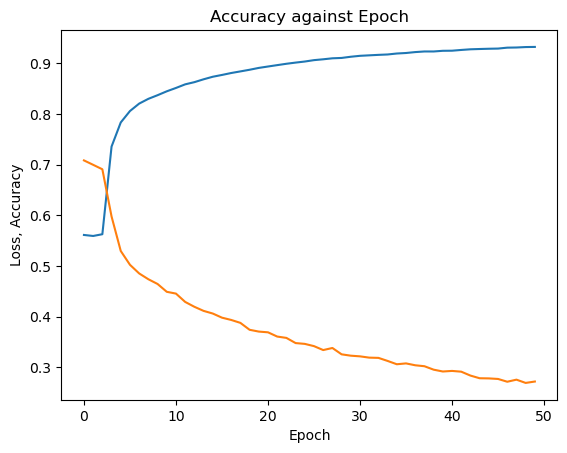

In [36]:
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["loss"])
plt.title("Accuracy against Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss, Accuracy")
plt.show()

In [37]:
model.evaluate(test_data)

106/106 [==============================] - 3s 29ms/step - loss: 0.2365 - accuracy: 0.9325


[0.23648634552955627, 0.9324744343757629]

In [38]:
tf_keras.models.save_model(
    model, "./model/model_v2.0.keras", overwrite=True
)